In [2]:
#import wget
import os
import glob
import random
import numpy as np
import os,shutil
import matplotlib 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from torch.utils.data import Dataset
from skimage.transform import resize
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms


In [3]:

mydir = r'C:\Users\s182354\Downloads\Warwick QU Dataset (Released 2016_07_08)'
# C:\Users\炸酱面\Downloads\project\warwick_qu_dataset_released_2016_07_08\Warwick QU Dataset (Released 2016_07_08)
pathDir =  os.listdir(mydir)   


In [4]:
# separate dataset to 3 class : testA, test B, train and its masks.
testsetA = []
testsetB = []
trainset = []
testmaskA = []
testmaskB = []
trainmask = []

for allDir in pathDir:      
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==True:     

        testmaskA.append(allDir)
        
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==False:
  
        testsetA.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==True:
       
        testmaskB.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==False:

        testsetB.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==True:
        
        trainmask.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==False:
        
        trainset.append(allDir)

#Build new dataset root  
newdir = os.getcwd()
raw_img_train_location = newdir+os.sep+'train'+os.sep+'raw'
raw_img_testA_location = newdir+os.sep+'testA'+os.sep+'raw'
raw_img_testB_location = newdir+os.sep+'testB'+os.sep+'raw'
anno_img_train_location = newdir+os.sep+'train'+os.sep+'anno'
anno_img_testA_location = newdir+os.sep+'testA'+os.sep+'anno'
anno_img_testB_location = newdir+os.sep+'testB'+os.sep+'anno'


if not os.path.isdir(raw_img_train_location):
    os.makedirs(raw_img_train_location)
if not os.path.isdir(raw_img_testA_location):
    os.makedirs(raw_img_testA_location)
if not os.path.isdir(raw_img_testB_location):
    os.makedirs(raw_img_testB_location)

if not os.path.isdir(anno_img_train_location):
    os.makedirs(anno_img_train_location)
if not os.path.isdir(anno_img_testA_location):
    os.makedirs(anno_img_testA_location)
if not os.path.isdir(anno_img_testB_location):
    os.makedirs(anno_img_testB_location)

def copy_img(path,list):
    for i in range(len(list)):
        new_obj_name = list[i]
        shutil.copy(mydir+'\\'+new_obj_name,path+'\\'+new_obj_name)

copy_img(raw_img_train_location,trainset)
copy_img(raw_img_testA_location,testsetA) 
copy_img(raw_img_testB_location,testsetB)
copy_img(anno_img_train_location,trainmask)
copy_img(anno_img_testA_location,testmaskA)
copy_img(anno_img_testB_location,testmaskB)
    
    

In [5]:
# sort the dataset to make raw images and its masks are corresponding.

def namesort(path,way):
    # 0 for raw, 1 for anno
    labelList = []  # 类标签列表
    datasetList = listdir(path)
    datasetload = []
    if way==0:
        list.sort(datasetList,key=lambda x: int(x[6:-4]))
    else:
        list.sort(datasetList,key=lambda x: int(x[6:-9]))
    for i in range(len(datasetList)):
        temp=imread(path+"\\"+datasetList[i])
        datasetload.append(temp)
    return datasetList,datasetload

(testsetA,testsetAraw) = namesort("testA/raw",0)
(testmaskA,testmaskAanno) = namesort("testA/anno",1)
(testsetB,testsetBraw) = namesort("testB/raw",0)
(testmaskB,testmaskBanno) = namesort("testB/anno",1)
(trainset,trainsetraw) = namesort("train/raw",0)
(trainmask,trainmaskanno) = namesort("train/anno",1)




In [40]:
from skimage.transform import resize
size = (400,400)
X = [resize(x,size,mode='constant',anti_aliasing=True) for x in testsetAraw]
Y = [resize(y,size,mode='constant',anti_aliasing=False) for y in testmaskAanno]
Z = [resize(z,size,mode='constant',anti_aliasing=True) for z in testsetBraw]
P = [resize(p,size,mode='constant',anti_aliasing=False) > 0.5 for p in testmaskBanno]


In [7]:
#crop images to get larger dataset.

newdir = os.getcwd()

raw_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'raw'

anno_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'anno'



if not os.path.isdir(raw_img_train_cropped_location):
    os.makedirs(raw_img_train_cropped_location)

if not os.path.isdir(anno_img_train_cropped_location):
    os.makedirs(anno_img_train_cropped_location)



def crop_img(raw_picture,anno_picture,crop_size,path1,path2):
    count =0
    ##raw_picture：raw images, anno_picture:anno images，path1:raw path，path2:anno path
    for i in range(len(raw_picture)):
        for j in range(2):
            raw_img = raw_picture[i]
            anno_img = anno_picture[i]
            x_shape = raw_img.shape[0]-crop_size
            y_shape = raw_img.shape[1]-crop_size
            x1 = random.randint(0,int(x_shape/2))
            x2 = random.randint(int(x_shape/2),x_shape)
            y1 = random.randint(0,int(y_shape/2))
            y2 = random.randint(int(y_shape/2),y_shape)
            if j == 0:
                cropped_raw_img = raw_img[x1:x1+crop_size,:]
                cropped_raw_img = cropped_raw_img[:,y1:y1+crop_size]
                cropped_anno_img = anno_img[x1:x1+crop_size,:]
                cropped_anno_img = cropped_anno_img[:,y1:y1+crop_size]
            else:
                cropped_raw_img = raw_img[x2:x2+crop_size,:]
                cropped_raw_img = cropped_raw_img[:,y2:y2+crop_size]
                cropped_anno_img = anno_img[x2:x2+crop_size,:]
                cropped_anno_img = cropped_anno_img[:,y2:y2+crop_size]
            if cropped_anno_img.shape[0]!=400 or cropped_anno_img.shape[1]!=400:
                print('error')
            count = count+1
            Image.fromarray(cropped_raw_img).save(path1+os.sep+str(count)+'.png')
            Image.fromarray(cropped_anno_img).save(path2+os.sep+str(count)+'.png')
    
    list1 = os.listdir(path1)
    list2 = os.listdir(path2)
    
    return list1,list2 


[trainset,trainmask]=crop_img(trainsetraw,trainmaskanno,400,raw_img_train_cropped_location,anno_img_train_cropped_location)


In [8]:
#IMAGE AUGMENTATION 
transform = transforms.Compose(
    [transforms.ToTensor()]
)



def batch_generator(Type,img_list, anno_list, batch_size, num_of_classes=2,transform=transform):
    images=[]
    annos=[]
    for i in range(batch_size):

        rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))

        if Type=='train':
            img = np.array(Image.open(img_list[rand_int]))
            anno = np.array(Image.open(anno_list[rand_int]).convert("L"))
            img=transform(img)
        if Type=='test':
            img=img_list[rand_int]
            anno=anno_list[rand_int]
        img=np.array(img)
        images.append(img)
        anno[anno>0] = 1
        anno_reshaped = np.zeros((anno.shape[0], anno.shape[1], num_of_classes))
    
        for i in range(num_of_classes):

            anno_reshaped[:, :, i][anno == i] = 1
        
        annos.append(anno_reshaped)
#    print(images[0].shape)
#    print(len(images))
    images=np.array(images)
    annos=np.array(annos)


    return images, annos
    
    

path_to_images = 'C:\\Users\\s182354\\Downloads\\Segmentation.ipynb\\train\\cropped\\raw'
path_to_annotations = 'C:\\Users\\s182354\\Downloads\\Segmentation.ipynb\\train\\cropped\\anno'
img_list = sorted(trainset)
anno_list = sorted(trainmask)
img_list = glob.glob(path_to_images+os.sep+"*.png")
anno_list = glob.glob(path_to_annotations+os.sep+"*.png")




batch_size=5
images, annos = batch_generator('train',img_list, anno_list,batch_size,2,transform)


torch.Size([5, 3, 400, 400])


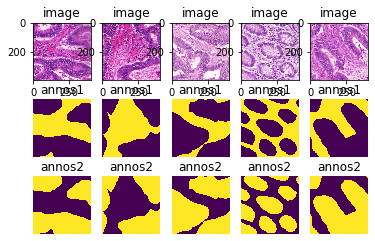

In [9]:
images=np.array(images)
annos=np.array(annos)
images = torch.from_numpy(images)

print(images.shape)

for k in range(batch_size):
    
    imshow = images.permute(0,2,3,1)
    plt.subplot(3, 5, k+1)
    plt.imshow(imshow[k,:,:,:])
    plt.title('image')
    plt.subplot(3, 5, k+6)
    plt.imshow(annos[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 5, k+11)
    plt.imshow(annos[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

In [10]:
#check batch and show some data

#images = torch.from_numpy(images)
annos = torch.from_numpy(annos)
annos = annos.permute(0,3,1,2)
print(images.shape)
print(annos.shape)


# plt.imshow(images[1,:,:,:])
# plt.imshow()
# plt.imshow(images[1,:,:,:])




torch.Size([5, 3, 400, 400])
torch.Size([5, 2, 400, 400])


In [11]:

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0=nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec0=nn.BatchNorm2d(64)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec1=nn.BatchNorm2d(64)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2=nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(400)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 2, 3, padding=1)
        self.bn_dec3=nn.BatchNorm2d(64)
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.bn_dec0(self.upsample0(b))))
        d1 = F.relu(self.dec_conv1(self.bn_dec1(self.upsample1(d0))))
        d2 = F.relu(self.dec_conv2(self.bn_dec2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec3(self.upsample3(d2)) ) # no activation
        d3 = torch.softmax(d3,dim=1)
        return d3
    
    

In [12]:
net=SegNet()
print(net)

SegNet(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1

In [13]:
import torch.optim as optim

criterion = nn.BCELoss() 

optimizer = optim.Adam(net.parameters(), lr=0.001)

#def bce_loss(y_real, y_pred):
#    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
print(net.parameters())

<generator object Module.parameters at 0x00000246C21FEB88>


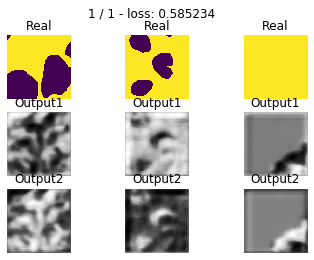

Finished Training


In [20]:
num_epoch = 1 
steps=10
avg_loss=0.0
# steps = 3 
for epoch in range(num_epoch):  
    running_loss = 0.0
  
    print('* Epoch %d/%d' % (epoch+1, num_epoch))
    net.train()
    for step in range(steps):
        images, annos = batch_generator('train',img_list, anno_list,batch_size, 2)
        images = torch.from_numpy(images)
        annos = torch.from_numpy(annos)
        annos = annos.float()
        annos = annos.permute(0,3,1,2)
        optimizer.zero_grad()
        outputs = net(images)
      
    
        loss = criterion(outputs, annos)
        loss.backward()
        optimizer.step()
        running_loss = loss 

        if step < 34:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss))
        
        running_loss = 0.0
        avg_loss += loss
    avg_loss =avg_loss/steps
    print(' -- loss: %f' % avg_loss)       

    

    Y_hat = net(images).detach().cpu()
    clear_output(wait=True)
    imshow=annos.permute(0,2,3,1)
    outshow=Y_hat.permute(0,2,3,1)
    
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow[k,:,:,0])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Output1')
        plt.axis('off')
        
        plt.subplot(3,3,k+7)
        plt.imshow(outshow[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Output2')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, num_epoch, avg_loss))
    plt.show()
print('Finished Training')

In [21]:
net.zero_grad()
for p in net.parameters():
    print('data',p.data)
    print('grad',p.grad)


data tensor([[[[-0.1658, -0.0070, -0.1618],
          [-0.1190, -0.1700, -0.0098],
          [-0.0716,  0.1450, -0.1345]],

         [[ 0.0834,  0.1508, -0.0049],
          [-0.0021,  0.0429, -0.1053],
          [-0.1177,  0.0978, -0.1531]],

         [[-0.0374, -0.1431, -0.1609],
          [ 0.0592, -0.0359, -0.0345],
          [ 0.0779, -0.1116, -0.1224]]],


        [[[-0.1655,  0.0925, -0.1292],
          [-0.1328, -0.1700, -0.0092],
          [ 0.0438,  0.1625,  0.1736]],

         [[ 0.1096,  0.1758,  0.0087],
          [-0.0471, -0.1720, -0.0297],
          [-0.1548,  0.1697, -0.0534]],

         [[-0.0885,  0.0487, -0.1481],
          [ 0.1854,  0.1478, -0.0593],
          [ 0.1349,  0.1696,  0.0901]]],


        [[[ 0.0722,  0.0957, -0.0606],
          [ 0.0235,  0.1025, -0.0974],
          [ 0.1829, -0.0905,  0.1927]],

         [[-0.1919, -0.0337, -0.0475],
          [ 0.1828, -0.1471, -0.1312],
          [-0.1317, -0.1652, -0.0206]],

         [[-0.1575, -0.1369,  0.1094],


          [-0.0156,  0.0098,  0.0413]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
       

          [ 0.0026, -0.0296, -0.0256]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
       

          [ 1.4731e-02,  3.1476e-02, -4.5894e-02]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 

          [ 2.8797e-02, -1.2215e-02,  2.3343e-02]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 

          [-2.9600e-02,  1.2912e-02, -9.4474e-03]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 

          [-1.4641e-03, -1.7343e-02, -1.6640e-02]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 

          [-0.0092,  0.0341,  0.0215]]]])
grad tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
       

          [0., 0., 0.]]]])
data tensor([-0.0188, -0.0098])
grad tensor([0., 0.])
data tensor([0.9902, 0.9869, 0.9836, 0.9921, 0.9968, 0.9917, 0.9916, 0.9935, 0.9935,
        0.9911, 0.9868, 0.9999, 0.9917, 0.9952, 0.9913, 0.9891, 0.9900, 0.9883,
        0.9945, 0.9939, 0.9966, 0.9903, 0.9892, 0.9858, 0.9966, 0.9984, 0.9920,
        0.9934, 0.9852, 0.9844, 0.9929, 0.9889, 0.9835, 0.9895, 0.9924, 0.9929,
        0.9983, 0.9945, 0.9851, 0.9961, 0.9861, 0.9860, 0.9872, 0.9919, 0.9904,
        0.9903, 0.9969, 0.9892, 0.9918, 0.9932, 0.9957, 0.9877, 0.9880, 0.9878,
        0.9937, 0.9929, 0.9877, 0.9887, 0.9902, 0.9887, 0.9849, 0.9924, 0.9954,
        0.9949])
grad tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
data tensor([ 0.0035, -0.0084,  0.0009,  0.0025, -0

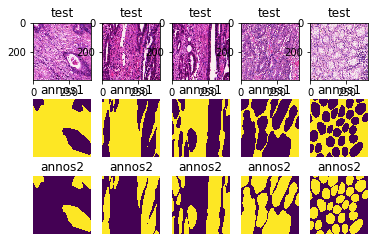

In [42]:
x,y = batch_generator('test',X, Y,batch_size, 2)
x=np.array(x)
x = torch.from_numpy(x)
y=np.array(y)
y = torch.from_numpy(y)

for k in range(batch_size):
    
    #imshow = X.permute(0,3,1,2)
    #outshow = Y.permute(0,3,1,2)
    plt.subplot(3, 5, k+1)
    plt.imshow(x[k,:,:,:])
    plt.title('test')
    plt.subplot(3, 5, k+6)
    plt.imshow(y[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 5, k+11)
    plt.imshow(y[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

In [43]:
# print(testsetAraw[0].shape)
test_step=12
net.eval()
for step in range(test_step):
    test, annoA = batch_generator('test',X, Y,batch_size, 2)
    
    test=np.array(test)
    test = torch.from_numpy(test)
    test = test.float()
    test = test.permute(0,3,1,2)

    annoA=np.array(annoA)
    annoA = torch.from_numpy(annoA)
    annoA = annoA.float()
    annoA = annoA.permute(0,3,1,2)
    
    net.zero_grad()
    pred = net(test)
    prediction.save(os.path.join(ckpt_path, args['exp_name'], 'test', img_name + '.png'))
#https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/eval/eval_voc.py
#     loss = criterion(pred, annoA)
    
#     running_loss += loss.data 

#     if step < 34:   
#         print('[%d, %5d] loss: %.3f' %
#                 (epoch + 1, step + 1, running_loss / batch_size))
#     running_loss = 0.0
#     avg_loss += loss / test_step
# print(' -- loss: %f' % avg_loss)       



[1,     1] loss: 0.193
[1,     2] loss: 0.196
[1,     3] loss: 0.181
[1,     4] loss: 0.181


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1843200000 bytes. Buy new RAM!


In [ ]:
from PIL import Image

import numpy as np

from sklearn.metrics import f1_score

import glob

import os





class ColorChange:

    def __init__(self):

        self.colors = {

            'background': [0, 0, 0, 0],

            'black': [0, 0, 0, 255],  # Cell - Gland

#             'green': [0, 255, 0, 255],  # Crop - Brazil

#             'yellow': [255, 255, 0, 255],  # Weed - Brazil

#             'gray': [128, 128, 128, 255], # Weed - Eskild

#             'white': [255, 255, 255, 255], # Crop - Eskild

        }



    def rgba_to_mask(self, img):

        ''' Input (H,W,4), output (H,W) '''

        mask = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)

        for i, color_value in enumerate(list(self.colors.values())):

            mask[np.sum(img == color_value, axis=2) == 4] = i

        return mask



project = 'gland_images'

dataset = 'gland'



annotations_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/annotations'

predictions_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/predictions'

score_path = os.getcwd()+os.sep+project+os.sep+dataset



annotations_list = sorted(glob.glob(annotations_path+'/*.png'))

predictions_list = sorted(glob.glob(predictions_path+'/*.png'))



f1 = 0



for idx in range(len(predictions_list)):

    anno = Image.open(annotations_list[idx]).convert('RGBA')

    anno = np.uint8(anno)

    anno = ColorChange().rgba_to_mask(anno)

    pred = Image.open(predictions_list[idx]).convert('RGBA')

    pred = np.uint8(pred)

    pred = ColorChange().rgba_to_mask(pred)

    for classes in np.unique(anno):

        if classes == 0:

            continue

    y_pred = (pred==classes)*1

    y_true = (anno==classes)*1

    f1 += f1_score(y_true.reshape(-1), y_pred.reshape(-1), average='macro')



f1 /= len(predictions_list)

f = open(score_path+"/f1_score.txt", "w")

f.write("The f1 score is : {0}".format(f1))

f.close()



print("F1 score for {0} is {1}".format(dataset, f1))

In [ ]:

def peter(a,b,oper=None):
    
    if oper == True:
         y=a+b
    
    else:
         y=a*b
    return y

In [ ]:
a=peter(2,3,oper=False)
print(a)